This code reads the merged dataframe (LinkedIn + WoS + GS), and the list with the university ranking, and merge those.
On the other hand, i calculate equal bins (buckets) for certain variables: ['total_pubs','h_index','i10index','t_citations','max_citations','num_journals','mean_IF','max_IF','num_grants','t_funding','t_deflated_funding','num_faculty']
and create extra columns with the range of values each person belongs to (5 quantiles), instead of the exact value, so anonymize them.


In [2]:
%matplotlib inline  
import matplotlib.pyplot as plt   
import pandas as pd
import numpy as np
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import scipy
import operator
import difflib
from IPython.core.display import display,HTML
try:
    import cPickle as pickle     #it is faster than pickle!
except:
    import pickle
    
import unicodedata

    
display(HTML("<style>.container { width:100% !important; }</style>"))  # to make the notebook use the entire width of the browser

In [3]:
flag_macro_field= 1     #1: only 5 fields, 0: around 30 fields

bucket_size=25.   # for binning the individual variables

drop_missing_emails=1   # or 0   # to drop rows without email







In [14]:
path_merge_linux='/home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/'
#filename="Merged_linkedin-WoS_GS_extra70univ.pickle"
#filename_merged="Merged_linkedin-WoS_GS_extra70univ.pickle"
                 
filename_merged="Merged_linkedin-WoS_GS_extra70univ_added_num_coauth_all_lines.pickle"

#%time df = pd.read_excel(open(path_merge_linux+filename.split(".")[0]+".xlsx",'rb'))

# print "done reading xlsx"

%time df = pd.read_pickle(path_merge_linux+filename_merged)
print df.shape

# df.to_pickle(path_merge_linux+filename.split(".pickle")[0]+".pickle")
  
# print "re-dumpling pickle done"




CPU times: user 5.99 s, sys: 776 ms, total: 6.77 s
Wall time: 6.78 s
(224999, 177)


In [5]:
for c in df.columns:
    print c

full_name_linkedin
Current_Title
Email
University_linkedin
School_college
Department_linkedin
Url
CV_Url
Linkedin_Url
Starting_Year_Current_Position
Institution_Bachelors_Degree
Field_Bachelors_Degree
Years_Bachelors_Degree
Institution_Masters
Field_Masters
Years_Masters
Institution_Phd
Field_Phd
Years_Phd
Previous_Title_0
Previous_Institution_0
Years_0
Department_0
Previous_Title_1
Previous_Institution_1
Years_1
Department_1
Previous_Title_2
Previous_Institution_2
Years_2
Department_2
Previous_Title_3
Previous_Institution_3
Years_3
Department_3
Previous_Title_4
Previous_Institution_4
Years_4
Department_4
Previous_Title_5
Previous_Institution_5
Years_5
Department_5
Previous_Title_6
Previous_Institution_6
Years_6
Department_6
Previous_Title_7
Previous_Institution_7
Years_7
Department_7
Previous_Title_8
Previous_Institution_8
Years_8
Department_8
Previous_Title_9
Previous_Institution_9
Years_9
Department_9
Previous_Title_10
Previous_Institution_10
Years_10
Department_10
Previous_Title_11

In [15]:
# df.groupby('ranking_University').size()
cont_num_complete_rows =0.
for item in pd.isnull(df['Email']):
    if item ==False:
        cont_num_complete_rows +=1
print  df.shape, "# rows with email:",cont_num_complete_rows

(224999, 177) # rows with email: 203161.0


In [6]:
#df[['full_name_linkedin','total_pubs','num_coauthors','num_papers_1st','num_papers_last','num_papers_solo','list_pub','num_citations','publ_seq']].head(30)


In [17]:
if drop_missing_emails ==1:
    df=df.dropna(subset=["Email"])
    
print "with email info:", df.shape

df.head()

# df_complete_info=df[['full_name_linkedin','University_linkedin', 'total_pubs','num_citations','num_papers_last']].dropna(how='any')  # by default, dropna drops a row if ANY  of the indicated fields are missing (i can also set it to if ALL the fields are missing: how='all')

# print df_complete_info.shape

with email info: (203161, 177)
(75034, 5)


In [8]:
# print df.shape
# print df[['Department_linkedin']].dropna(how='any').shape  # by default, dropna drops a row if ANY  of the indicated fields are missing (i can also set it to if ALL the fields are missing: how='all')


In [9]:
# df[['full_name_linkedin','Department_linkedin','University_linkedin','total_pubs','num_papers_1st','num_papers_last','num_papers_solo','num_coauthors','list_pub']].dropna(how='any')


In [10]:
# print df.shape
# for item in df.columns:
#     print item

In [11]:
# len(df.Department_linkedin.unique())

# print "Type the field each department belongs to, from the following options:"
# print "science physics arts sociol(ogy) anthr(opology) math bio lang chem lit cs history music philos(ophy) government finance management psy(cology) asian stats envirom(ental) marketing" 
# print "epi(demiology) medicine gen(etics) health immun(ology) busi(nes) cancer pharm film writing neuro"
# print 
# print 

# dict_dept_field={}
# cont=0
# for dept in sorted(df.Department_linkedin.unique()):
   
#     if cont >=3000:
#        print dept
#        my_input=raw_input()
#        if len(my_input) >2:
#             dict_dept_field[dept]=my_input
#        else: 
#             dict_dept_field[dept]=dept.lower()

#        if my_input =="XXXX"    :
#             break
#     cont +=1
# print "\ndone!", cont

In [18]:
#########REPLACE THIS FILE BY THE NEW ONE??




#### input file (ALL disambiguated WoS)
path='/home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/'
filename_dict='aux_dict_dept_field.dat'   # file created by hand, giving a field to each (unique) department 

new_dict_dept_field={}
cont =0
flag=0
with open(path+filename_dict) as f:
    for line in  tqdm_notebook(f):  # line is a str        
        line=line.strip("\n").lower()  
        
       
        if flag==0:            
            new_dict_dept_field[line]=None
            old_line=line
            flag=1
        
        else:
            if len(line)>0:
                new_dict_dept_field[old_line]=line.lower()
            else: 
                new_dict_dept_field[old_line]=old_line.lower()
                                                                                                                                                                   
            #print "---",old_line, "     ", new_dict_dept_field[old_line]
            flag=0
        cont +=1
        

def find_field(dept,dicc):
    
    field=""
    #print dept,
   
      
    try:         # to skip non-numbers (that i have previously transformed into ''  ):
        field= new_dict_dept_field[dept].lower()
        #print field        
        
        return field
                    
    except : 
        return "other"
    
        
###############################

    
    
######## i create the new field (and i will run it again after refining the dict)
df['Field'] = df['Department_linkedin'].apply(find_field,args=[new_dict_dept_field])

df['Department_linkedin']=df['Department_linkedin'].str.lower()

#df['Field'] = df['Department_linkedin'].fillna('').apply(find_field,args=[new_dict_dept_field])
  

In [13]:
df.tail()

,full_name_linkedin,Current_Title,Email,University_linkedin,School_college,Department_linkedin,Url,CV_Url,Linkedin_Url,Starting_Year_Current_Position,...,update_date,num_coauthors,num_papers_double_check,num_papers_1st,num_papers_last,num_papers_solo,list_pub,num_citations,publ_seq,Field
224994,omofolabo ajayisoyinka,Professor Emeritus,omofola@ku.edu,University of Kansas,College of Liberal Arts & Sciences,"women, gender & sexuality studies program",http://wgss.ku.edu/faculty,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,other
224995,katie batza,Assistant Professor,batza@ku.edu,University of Kansas,College of Liberal Arts & Sciences,"women, gender & sexuality studies program",http://wgss.ku.edu/faculty,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,other
224996,ann schofield,"Professor, Interim Chair, WGSS (Spring 2016)",schofield@ku.edu,University of Kansas,College of Liberal Arts & Sciences,"women, gender & sexuality studies program",http://wgss.ku.edu/faculty,NaN,NaN,NaN,...,NaN,0.0,8.0,8.0,8.0,8.0,A1954XY07800005|000330456700057|A1992JN8360000...,46.0,A1954XY07800005:0|000330456700057:0|A1992JN836...,other
224997,margaret marco,"Associate Professor, Oboe, Director, Division ...",mmarco@ku.edu,University of Kansas,School of Music,woodwinds,http://music.ku.edu/woodwinds/faculty,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,other
224998,eric stomberg,"Professor, Bassoon, Associate Dean for Perform...",stomberg@ku.edu,University of Kansas,School of Music,woodwinds,http://music.ku.edu/woodwinds/faculty,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,other


In [14]:
# len(df.Field.unique())  #473

In [15]:
# print len(set(new_dict_dept_field.values()))      # keys: 3246 (dept),  values: 473 (fields)
# #raw_input()

# len(set(new_dict_dept_field.values()))


# # for llave in new_dict_dept_field:
# #     print llave, "     ",new_dict_dept_field[llave]
# #     raw_input()

In [16]:
# for d in new_dict_dept_field:
#     if new_dict_dept_field[d]=="other":
#         print d, new_dict_dept_field[d]

# new_dict_dept_field

In [19]:
### i modify/group the values of certain FIELD in the dict.  dept-field


for dept in new_dict_dept_field:
    field=new_dict_dept_field[dept]
    
    
#     if field in list_small_fields:       
#         new_dict_dept_field[dept]="other"
   
    
    
    if 'assistant' in dept or 'associate' in dept  or 'dean' in dept or  "office" in dept or 'post-doctoral' in dept  or 'provost' in dept or 'undergrad' in dept or 'academic' in dept\
    or 'services' in dept or 'instructor' in dept or 'facilit' in dept  or 'student' in dept  or   "college" in dept or "student" in dept or "school" in dept    or "admi" in dept\
    or "a faculty of leading scholars" in dept:
        new_dict_dept_field[dept]="other"                        
        
    if  "Facilit" in field      or  "Undergraduate Studies" in field    or "Undergraduate Education" in field    or "Servic" in field   or "Provost" in field  or "Dean" in field\
    or  "Post-doct" in field:               
        new_dict_dept_field[dept] ="other"
   
    if len(field.split(" "))>5:               
        new_dict_dept_field[dept] ="other"
        
        
    
    

    if field == "m"  or field == "med" or dept=="anatomy" or "patient" in dept   or "anesth" in dept or   "cancer" in field or    "cancer" in dept\
    or  "med " in dept  or "nurs" in dept or "infec" in dept or field ==  "me" or "medicine" in dept or field ==  "medicine" or field == "nutrition research" \
    or field=="dentistry" or field == "endo" or "endo" in dept or "ortho" in dept  or field =="dent"  or field == 'nursing' or field == 'nursin'    or field == 'nursion' \
    or "patho" in dept or "therap" in dept or "nutri" in dept or "anesth" in dept  or "derm" in dept or field== "derm" or field == "gyn"  or field == "vet" \
    or "aneurysm" in dept   or "surgery" in dept or "urol" in dept or "brain" in dept or "cardi" in dept or "pregnancy" in dept or "clinical" in dept or "cerebrovascular" in dept \
    or "physicians" in dept  or "dent" in dept  or "pediatric" in dept  or "surg" in dept or "urolog" in dept or "radiol" in dept or "radiat" in dept or "weight" in dept\
    or "gastroenterology" in dept   or "hematology" in dept or "johns hopkins" in dept  or "otolaryngology" in dept or "otorhinolaryngology" in dept  or "pulmonary" in dept \
    or "rehabilitation" in dept    or "restorative" in dept or "respiratory" in dept  or "sales" in dept or "thoracic" in dept:
                        
        new_dict_dept_field[dept]="medicine dentistry and nursing"        
                 
        
   
       
    elif field == "lang" or field == "languages" or field =="lang " or "lang" in dept or "litera" in dept   or field == "leng" or field == 'let' or field == 'lit'\
    or field=="writing" or "writing" in dept or field=="literature" or "language" in dept  or "scandinavian" in dept:
        new_dict_dept_field[dept]="lit and languages"
        
                                       
    elif field == "busin" or field=="busni"  or field == "econ" or  field== "bunis" or field =='operations research' or field =='marketing'  or field == 'accounting'\
    or field == "account "   or field == "account"  or "financ" in dept or  field == "finances" or "manag" in field or field == "mang"   or field== "employment relations"\
    or "account" in dept or "managemen" in dept  or "business" in dept   or "economics" in dept  or "hospitality" in dept or "leader" in dept  or 'marketing' in dept\
    or "risk" in dept or "strategy" in dept or "supply" in dept  or "tourism" in field:
        new_dict_dept_field[dept]="business econ and finances"
                                              
        
    elif field == "dance" or "visual" in dept or "drama" in dept or field=="art" or "art " in dept or " art" in dept or "film" in dept or field=="film" or "media" in dept:
        new_dict_dept_field[dept]="art and film"   
       
          
    elif field == "arch"  or  field =='construction science'  or field =='architecture'  or field == "desing"  or field == "design" or "design" in dept or "planning" in dept :
        new_dict_dept_field[dept]="architecture and design"    
                               
        
    elif field == "african" or field == "asian" or field == 'native am'  or field == 'am'    or field == 'american' or field == "anthr":
        new_dict_dept_field[dept]="anthropology"        
            
       
    elif field == "agri"   or  field == "agric"  or field=='dairy science' or 'poultry' in dept or "hortic" in dept  or "avian" in dept or "vitic" in dept\
    or "agri" in dept or "agro" in dept or "crop" in dept  or "soil" in dept:
        new_dict_dept_field[dept]="agriculture and farming"
        
        
    elif field == "bio" or  "biol" in dept or "cell" in dept  or field == "gen" or "botany" in dept or field=="genetics" or "genomic" in dept  or field=="science":
        new_dict_dept_field[dept]="biology"
    
    
    


    elif field == "aero"  or "aero" in dept:
        new_dict_dept_field[dept]="aerospace"



    elif field == "pharm":
        new_dict_dept_field[dept]="pharmacology"
  
           
   
    elif field == "epid"  or field =="immun"  or "immun" in dept or "epidemiology" in dept:
        new_dict_dept_field[dept]="epidemiology and immunology"

    elif field == "neuro"  or field == "neuron"  or "neuro" in dept:
        new_dict_dept_field[dept]="neuroscience"  
        
    elif field == "psy"   or field == "pys"   or "behav" in dept  or field == 'occupational therapy' or "devel" in dept:
        new_dict_dept_field[dept]="psychology"      
        
                                                   
        
    elif field == "che"   or field == "chem" or 'chem' in dept:
        new_dict_dept_field[dept]="chemistry"     

           
    elif field == "phy" or field =="phys"  or field == "astro" or "physics" in dept:
        new_dict_dept_field[dept]="physics"
        
    
    elif field == "health"  or  field =="public" or field== 'epid / adm' or field ==  'exercise sciences' or field ==   'family science'  or field ==  'exercise science'or field ==  'kinesiology' or "social" in dept:
        new_dict_dept_field[dept]="public health"                
        
         
   
                              
    elif field == "eng"  or field == "en"  or  field == "nse"   or  "engin" in dept  or field== 'eecs' or field== 'ioe' or field =="mitmeche" or "engineering" in dept:
        new_dict_dept_field[dept]="engineering"                  
                                   
      
    elif field == "edu" or "education" in dept  or "curriculum" in dept:
        new_dict_dept_field[dept]="education"
        
 
        
    elif field == "cs" or field=="information"  or field == 'library' or "comput" in dept  or "data science" in dept:
        new_dict_dept_field[dept]="computer science"
      
    elif field == "comm" or  field ==  "commun" or "journalism" in dept:
        new_dict_dept_field[dept]="communication"
        
    elif field == "eco"  or  field == "eg"  or  field == "ecol" or "ecol" in dept or  field ==  "urban entomology" or field == "eviron"  or  field == "envir"\
    or  field == "environ"  or "environmental" in dept  or "forest" in dept  or "wildlife" in dept  or "zoology" in dept:
        new_dict_dept_field[dept]="ecology and environment"
                        
    elif "law" in dept:
        new_dict_dept_field[dept]="law"              

        
         
    elif field == "musci" or "music" in dept:
        new_dict_dept_field[dept]="music"                       
        
  
    
      
    elif field == "geo" or "ocean" in dept or  field == 'oceanography' or "arid " in dept  or "geograp" in dept or "geol" in dept  or "geosc" in dept  or "hydrol" in dept\
    or "marine" in dept:
        new_dict_dept_field[dept]="earth"   
        
        
               
    elif field == "govern"  or field == "poli sci"   or "govern" in dept  or field == 'int rel'  or field == 'intern'    or field == 'international studies'\
    or field == 'international stu' or 'global' in field or field == 'mid easter'  or field == 'mid eastern'    or 'middle east' in dept or field == 'middle east'\
    or field == 'middle eastern'   or field == 'mid east' or "politic" in dept or "dispute" in field:
        new_dict_dept_field[dept]="poli sci and government"           
        
         

    
    elif field == 'digital humanities'  or field == 'museum studies' or field =="culture"  or "european" in dept   or field =='comparative studies'\
    or field == "interd"  or field=="honors"   or field == "hist"  or field == "history"   or field == "hst"  or field == "philos"  or  field =="ethics" or  field =="philosophy"\
    or "hist" in dept or field == "rel" or field == 'theatre' or field == 'theater' or field == "women"  or "mediterranean" in dept or "eurasian" in dept\
    or "medieval" in dept  or "rhetoric" in dept  or "letters" in field or "liberal" in field  or "disciplinary" in field:    
                        
        new_dict_dept_field[dept]="humanities"      
                        
          
                     
    
    elif field == 'stats'  or  field == 'math' or 'math' in dept or "stat" in dept:
        new_dict_dept_field[dept]="math and stats"
    

    
#     elif field == 'mugovernsic':
#         new_dict_dept_field[dept]="music"
    
    
    elif field == 'population center'   or field == 'sociol':
           new_dict_dept_field[dept]="sociology"  
    
    
   
   

        
            
            
    
    
lista=new_dict_dept_field.values()    
    
    

filename_pickle=path_merge_linux+"dict_department_field_no_bins_by_field.pickle"    
pickle.dump(new_dict_dept_field, open(filename_pickle, 'wb'))
print "written:",filename_pickle  


 
#####  i re-run this with the refined dict
df['Field'] = df['Department_linkedin'].apply(find_field,args=[new_dict_dept_field])
#df['Field'] = df['Department_linkedin'].fillna('').apply(find_field,args=[new_dict_dept_field])
  

    
    
    
    
    
    
    
    


written: /home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/dict_department_field_no_bins_by_field.pickle


In [18]:
len(sorted(list(set(new_dict_dept_field.values()))))



198

In [20]:
cont_small=0
# sorted(df_merged.ranking_University.unique())
#df[df['Field']=="water security"].shape
list_big_fields=[]
list_small_fields=[]

cont=0
for item in sorted(df.Field.unique()):
    size=len(df[df["Field"]==item])
    if size >= 50:
        #print item, size
        list_big_fields.append(item)
    else:
        list_small_fields.append(item)
        
        cont_small +=size
        #print item, size
    cont += size
    
print "# people:"    , cont    , "   in small depts", cont_small





for dept in new_dict_dept_field:
    field=new_dict_dept_field[dept]
    
    
    if field in list_small_fields :       
        new_dict_dept_field[dept]="other"
   

# people: 203161    in small depts 1235


In [21]:


if flag_macro_field==1:

    for dept in new_dict_dept_field.keys():
        field = new_dict_dept_field[dept]

        if field == "aerospace":
            new_dict_dept_field[dept]="science"                        

        elif  new_dict_dept_field[dept]=="agriculture and farming":
            new_dict_dept_field[dept]= "science"          

        elif new_dict_dept_field[dept]=="anthropology":
            new_dict_dept_field[dept]= "humanities"     

        elif new_dict_dept_field[dept]=="architecture and design":
            new_dict_dept_field[dept]=  "art"       

        elif new_dict_dept_field[dept]=="art and film":
            new_dict_dept_field[dept]= "art"    

        elif new_dict_dept_field[dept]=="biology":
            new_dict_dept_field[dept]= "science"  

        elif new_dict_dept_field[dept]=="business econ and finances":
            new_dict_dept_field[dept]= "business econ finances government"  

        elif new_dict_dept_field[dept]=="chemistry":
            new_dict_dept_field[dept]=  "science"   

        elif new_dict_dept_field[dept]=="communication":
            new_dict_dept_field[dept]=   "humanities"  

        elif new_dict_dept_field[dept]=="computer science":
            new_dict_dept_field[dept]="science"      

        elif new_dict_dept_field[dept]=="earth":
            new_dict_dept_field[dept]=   "science"  

        elif new_dict_dept_field[dept]=='ecology and environment':
            new_dict_dept_field[dept]= "science"     

        elif new_dict_dept_field[dept]=="education":
            new_dict_dept_field[dept]=  "humanities" 

        elif new_dict_dept_field[dept]=="engineering":
            new_dict_dept_field[dept]= "science"             

        elif new_dict_dept_field[dept]=="epidemiology and immunology":
            new_dict_dept_field[dept]=  "medicine dentistry nursing pharmacology"     

        elif new_dict_dept_field[dept]=="humanities":
            new_dict_dept_field[dept]=   "humanities"   

        elif new_dict_dept_field[dept]=="law":
            new_dict_dept_field[dept]= "humanities" 

        elif new_dict_dept_field[dept]=="lit and languages":
            new_dict_dept_field[dept]= "humanities" 

        elif new_dict_dept_field[dept]=="math and stats":
            new_dict_dept_field[dept]= "science" 

        elif new_dict_dept_field[dept]=="medicine dentistry and nursing":
            new_dict_dept_field[dept]=  "medicine dentistry nursing pharmacology"  

        elif new_dict_dept_field[dept]=="music":
            new_dict_dept_field[dept]=  "art"   

        elif new_dict_dept_field[dept]=="neuroscience":
            new_dict_dept_field[dept]= "science"   

        elif new_dict_dept_field[dept]=="other":
            new_dict_dept_field[dept]=  "other"   

        elif new_dict_dept_field[dept]=='pharmacology':
            new_dict_dept_field[dept]=  "medicine dentistry nursing pharmacology" 

        elif new_dict_dept_field[dept]=="physics":
            new_dict_dept_field[dept]= "science"         

        elif new_dict_dept_field[dept]=="poli sci and government":
            new_dict_dept_field[dept]= "business econ finances government"      

        elif new_dict_dept_field[dept]=="psychology":
            new_dict_dept_field[dept]=  "humanities"   

        elif new_dict_dept_field[dept]=="public health":
            new_dict_dept_field[dept]=  "humanities"                   

        elif new_dict_dept_field[dept]=="sociology":
            new_dict_dept_field[dept]= "humanities"               

            
            
            
            
    df['Field'] = df['Department_linkedin'].apply(find_field,args=[new_dict_dept_field])


In [22]:
for key in sorted(new_dict_dept_field):
    print key, "\t\t\t   ----",new_dict_dept_field[key]

a faculty of leading scholars 			   ---- other
academic advisement 			   ---- other
academic affairs 			   ---- other
academic and student affairs 			   ---- medicine dentistry nursing pharmacology
academic computing center 			   ---- science
academic learning center (halc) 			   ---- humanities
academic operations & planning 			   ---- business econ finances government
academic programs 			   ---- other
academics 			   ---- other
academy for creative media 			   ---- art
academy of international business 			   ---- business econ finances government
accountancy 			   ---- business econ finances government
accountancy, department of 			   ---- business econ finances government
accounting 			   ---- business econ finances government
accounting & mis 			   ---- business econ finances government
accounting and finance 			   ---- business econ finances government
accounting and information systems 			   ---- business econ finances government
accounting and information technology accounting 

In [23]:

    
    
if flag_macro_field==1:

    filename_pickle=path_merge_linux+"dict_department_macro_field.pickle"    
else:
    filename_pickle=path_merge_linux+"dict_department_field.pickle"    
        


pickle.dump(new_dict_dept_field, open(filename_pickle, 'wb'))
print "written:",filename_pickle  


 
#####  i re-run this with the refined dict
df['Field'] = df['Department_linkedin'].apply(find_field,args=[new_dict_dept_field])
#df['Field'] = df['Department_linkedin'].fillna('').apply(find_field,args=[new_dict_dept_field])
      

written: /home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/dict_department_macro_field.pickle


In [24]:
df[['Department_linkedin','Field']].tail(3)

,Department_linkedin,Field
224996,"women, gender & sexuality studies program",humanities
224997,woodwinds,art
224998,woodwinds,art


In [25]:
df.groupby('Field').size()

Field
art                                        12267
business econ finances government          15757
humanities                                 48418
medicine dentistry nursing pharmacology    44927
other                                      28638
science                                    53154
dtype: int64

In [26]:
df.shape

(203161, 178)

In [27]:

filename_top100="/home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/University_rankings_and_names/list_top_100universities.tsv"
df_top_100univ=pd.read_csv(filename_top100, sep='\t',usecols=['ranking_University','group_ranking20_University','group_ranking30_University', 'group_ranking50_University','University_linkedin'])#names=['ranking_University', 'University_linkedin'])#, header=None)

dict_univ_ranking=df_top_100univ.set_index('University_linkedin')['group_ranking30_University'].to_dict()
list_values_randking=dict_univ_ranking.values()

df_merged = pd.merge(df, df_top_100univ, how='left',on='University_linkedin')

df_top_100univ.head()

,ranking_University,group_ranking20_University,group_ranking30_University,group_ranking50_University,University_linkedin
0,1.0,1-20,1-30,1-50,Harvard University
1,2.0,1-20,1-30,1-50,Stanford University
2,3.0,1-20,1-30,1-50,University of California Berkeley
3,4.0,1-20,1-30,1-50,Massachusetts Institute of Technology
4,5.0,1-20,1-30,1-50,Princeton University


In [27]:
df_merged.shape

(225004, 182)

In [28]:
# #df_merged.tail(20000)
# list_missing_univ=[]

# for row in df_merged.iterrows():
# #     print row[1]
#     try:
#         ranking=int(row[1]["ranking_University"])
#     except :
#         list_missing_univ.append(row[1]["University_linkedin"])
#         print row[0]
        
# print list_missing_univ

In [29]:
#df_merged.groupby('University_linkedin').size()  # to count rows with a given value


In [30]:
# sorted(df_merged.ranking_University.unique())

   VAR: total_pubs  N: 75034   init. quantiles: 3001
    # quantiles: 5
   VAR: h_index  N: 8312   init. quantiles: 332
    # quantiles: 45
   VAR: mean_IF  N: 8312   init. quantiles: 332
    # quantiles: 79
   VAR: num_coauthors  N: 75034   init. quantiles: 3001
    # quantiles: 16
   VAR: num_papers_1st  N: 75034   init. quantiles: 3001
    # quantiles: 4
   VAR: num_papers_last  N: 75034   init. quantiles: 3001
    # quantiles: 4
   VAR: num_papers_solo  N: 75034   init. quantiles: 3001
    # quantiles: 2
   VAR: num_citations  N: 75034   init. quantiles: 3001
    # quantiles: 5
done


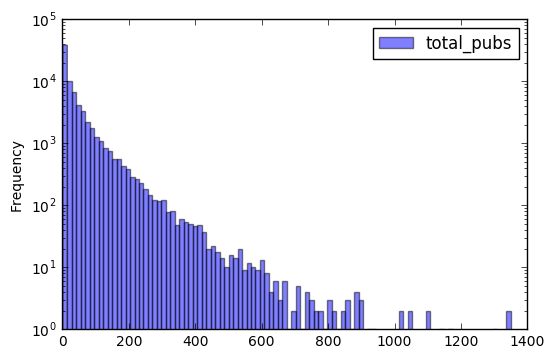

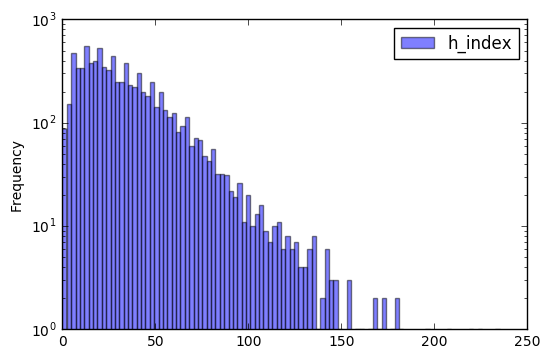

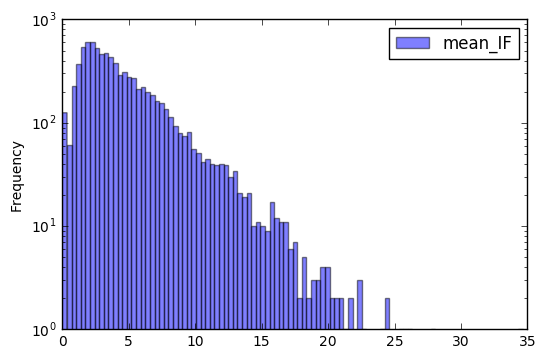

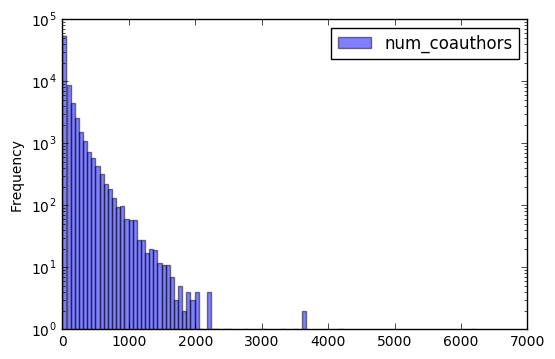

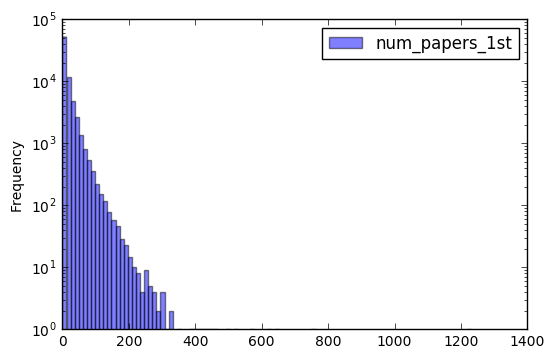

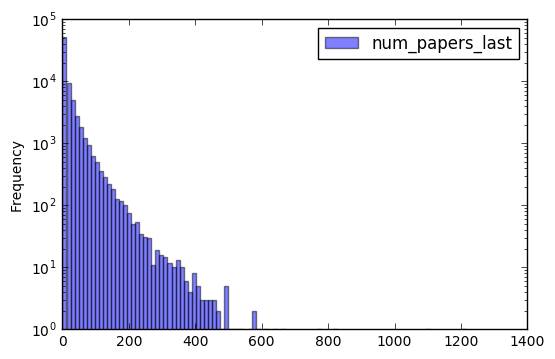

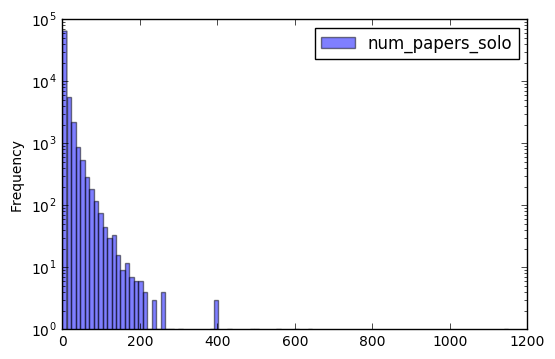

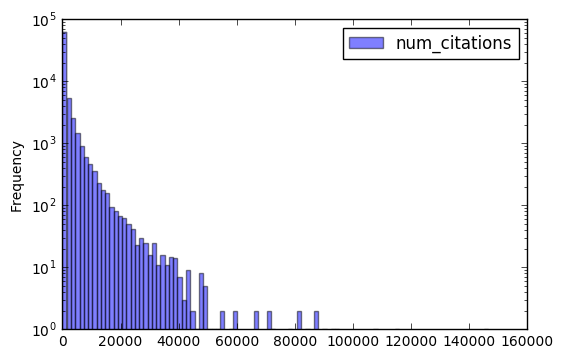

In [28]:
# df_sample=df[['mean_IF','h_index','num_journals']].plot.hist(bins=100, alpha=0.5,stacked=True)

# fig = plt.gcf()
# fig.savefig(path_merge_linux.split("Merged_LinkedIn_WoS/")[0]+'testing_multiple_hist.png', dpi=600)
# #df.plot.hist( alpha=0.5)



master_dict_column_dict_bins={}

# lista_columns=['total_pubs','h_index','i10index','t_citations','max_citations','num_journals','mean_IF','max_IF','num_grants','t_funding','t_deflated_funding','num_faculty',\
#               'num_coauthors','num_papers_1st','num_papers_last','num_papers_solo','num_citations']

lista_columns=['total_pubs','h_index','mean_IF','num_coauthors','num_papers_1st','num_papers_last','num_papers_solo','num_citations']
#lista_columns=['total_pubs','num_papers_last','num_papers_solo','num_citations']


for columna in lista_columns:        
   
#     ##### for printing out the histograms:    
#     Nbins=100
#     df_merged[[columna]].plot.hist(bins=Nbins, alpha=0.5,log=True, cumulative=False)
#     fig = plt.gcf()
#     fig.savefig(path_merge_linux.split("Merged_LinkedIn_WoS/")[0]+'hist_'+columna+"_"+str(Nbins)+'bins.png', dpi=600)
#     #####


    lista_values=df_merged[columna].dropna().tolist()  
    print "   VAR:",columna, " N:",len(lista_values), 

    
    if len(lista_values)>=1:
            
            quantiles = int(float(len(lista_values))/bucket_size)
            print "  init. quantiles:",quantiles
            if quantiles ==0:
                quantiles=1
            num_distict_values=len(set(lista_values))          
            
                
                
            
            
           # print  "   unique:", num_distict_values, "  min:", min(lista_values),"max:", max(lista_values), "  initial q:", quantiles,
            

             
        
            flag_problem_boundaries=0
            output=None
            dict_boundaries={}     
        
            flag_keep_going=1
            while flag_keep_going ==1:
                #print "while loooooping"
                if num_distict_values >1:
           
                
                    try:                        
                        output=pd.qcut(lista_values, quantiles, retbins=True)
                        flag_keep_going =0
                        flag_problem_boundaries=0  
                                                                    

                        for i in range(len( output[1])):
                            try:
                                llave=(output[1][i],output[1][i+1])
                                dict_boundaries[llave]=0
                            except IndexError: pass     
                        for item in lista_values:
                            for llave in dict_boundaries:
                                if item > llave[0] and item <= llave[1]:
                                    dict_boundaries[llave] +=1
                                    

                        list_counts=[]
                        lista_edges=[]
                        for llave in dict_boundaries:
                            lista_edges.append(llave[0])                
                            lista_edges.append(llave[1])

                            list_counts.append(dict_boundaries[llave])

                        lista_edges=sorted(list(set(lista_edges)))


                            
                            
                    except ValueError:
                        flag_keep_going =1
                        flag_problem_boundaries=1
                        quantiles -=1 
                        #print "   didnt work... trying q:", quantiles
                    if quantiles <= 1:  
                        flag_keep_going =0
                        flag_problem_boundaries=1
                       # print "not gonna work --> assigning just one bin"
                       
                   
                    
                    
                    
                else:
                    flag_problem_boundaries=1
                    flag_keep_going =0  
                    print "insuficient num distinct values"
                                                
            print "    # quantiles:", quantiles
                                                        
                              
            if flag_problem_boundaries==0:            
                #pass
              
            
                ##### for printing out the histograms:    
                Nbins=100#quantiles
                df_merged[[columna]].plot.hist(bins=Nbins, alpha=0.5,log=True, cumulative=False)
                fig = plt.gcf()
                fig.savefig(path_merge_linux.split("Merged_LinkedIn_WoS/")[0]+'hist_'+columna+"_"+str(Nbins)+'bins.png', dpi=600)
                #####

                

          
                
            else:  # all observations in one single bin
                llave=(min(lista_values), max(lista_values))    
                dict_boundaries = {llave: len(lista_values)}  
                print "all observations in one bucket"
               
               
                
                
    
            master_dict_column_dict_bins[columna]=dict_boundaries
    

                
              
#     else :  # if there are too few points
#             print "empty!", lista_values
            
#             lista_fields_too_small_buckets.append(field)
            
    
    
    
print "done"
    






In [32]:
for llave in master_dict_column_dict_bins:
    print llave, master_dict_column_dict_bins[llave]
    print 

num_papers_last {(0.0, 1.0): 10306, (4.0, 18.0): 20244, (1.0, 4.0): 11648, (18.0, 1216.0): 19641}

mean_IF {(0.048000000000000001, 0.753): 111, (5.256064935064936, 5.3783116883116877): 111, (2.9020000000000001, 2.976): 109, (4.983935064935066, 5.1210519480519494): 112, (11.107220779220782, 12.03688311688312): 111, (3.0640000000000001, 3.145): 111, (2.0209999999999999, 2.0814025974025974): 110, (5.5291428571428565, 5.6731818181818179): 111, (4.8464805194805214, 4.983935064935066): 111, (15.566753246753301, 34.661000000000001): 112, (5.3783116883116877, 5.5291428571428565): 111, (4.5990000000000002, 4.7269090909090909): 110, (0.9262337662337663, 1.0481558441558443): 111, (2.8181298701298703, 2.9020000000000001): 114, (9.6168311688311707, 10.274467532467538): 111, (2.212779220779221, 2.2768181818181819): 111, (1.1613896103896104, 1.2642337662337662): 111, (2.2768181818181819, 2.3319999999999999): 114, (3.5430000000000001, 3.6269999999999998): 111, (7.4162597402597461, 7.6799999999999997):

In [29]:
def find_group(numero,columna):
    
                    #total_pubs {(1.0, 2.0): 5209, (2.0, 7.0): 11367, (7.0, 22.0): 16516, (22.0, 56.0): 15517, (56.0, 1350.0): 15933}
    dict_boundaries=master_dict_column_dict_bins[columna]
#     print "\n",numero,
    value=np.nan
    try:         # to skip non-numbers (that i have previously transformed into ''  ):
        numero=float(numero)
        for llave in dict_boundaries:
                if numero >= llave[0] and numero <= llave[1]:
                    value=str(llave[0])+"-"+str(llave[1])        
#                     print value
#                     raw_input()
                    return value
                    
    except ValueError: 
#         print "nada!"
        return np.nan
        
###############################

    
# loop to create new group_columns from the original columns        
for llave in sorted(master_dict_column_dict_bins):    
    df_merged['group_'+llave] = df_merged[llave].fillna('').apply(find_group,args=[llave])
    print llave,'   group_'+llave


h_index    group_h_index
mean_IF    group_mean_IF
num_citations    group_num_citations
num_coauthors    group_num_coauthors
num_papers_1st    group_num_papers_1st
num_papers_last    group_num_papers_last
num_papers_solo    group_num_papers_solo
total_pubs    group_total_pubs


In [34]:
#lista=df["num_grants"].dropna().tolist()

In [35]:
df_merged.columns

Index([            u'full_name_linkedin',                  u'Current_Title',
                                u'Email',            u'University_linkedin',
                       u'School_college',            u'Department_linkedin',
                                  u'Url',                         u'CV_Url',
                         u'Linkedin_Url', u'Starting_Year_Current_Position',
       ...
           u'group_ranking30_University',     u'group_ranking50_University',
                        u'group_h_index',                  u'group_mean_IF',
                  u'group_num_citations',            u'group_num_coauthors',
                 u'group_num_papers_1st',          u'group_num_papers_last',
                u'group_num_papers_solo',               u'group_total_pubs'],
      dtype='object', length=190)

In [36]:
#############################  i glue here the part about bines by field:

In [37]:

# lista_fields=df_merged.Field.unique()

# master_dict_field_dict_colum_bines={}



# bucket_size=25.




# ###### i get bins for each variable and  by field

# lista_fields_too_small_buckets=[]

# for field in sorted(lista_fields):
                    
#     master_dict_field_dict_colum_bines[field]={}
    
#     df_selection=df_merged[df_merged.Field == field]   # i select only the rows that correspond to a given field
    
#     print "\n\nFIELD:",field, "  N:", df_selection.shape[0]

    

#     master_dict_column_dict_bins={}

#     lista_columns=['total_pubs','num_coauthors','num_papers_1st','num_papers_last','num_papers_solo','num_citations']

#     for columna in lista_columns:   
        
        
       
#         ##### for printing out the histograms:    
# #         Nbins=100
# #         df_selection[[columna]].plot.hist(bins=Nbins, alpha=0.5,log=True, cumulative=False)
# #         fig = plt.gcf()
# #         fig.savefig(path_merge_linux.split("Merged_LinkedIn_WoS/")[0]+'hist_'+columna+"_"+field.replace(" ","_")+"_"+str(Nbins)+'bins.png', dpi=600)
# #         #####


#         lista_values=df_selection[columna].dropna().tolist()  #df_selection['a'].drop_duplicates().values.tolist()   # get a list from a column (WITH repetitions if there are any)    
#         print "   VAR:",columna, " N:",len(lista_values),

    
    
    
#         if len(lista_values)>=1:
           
#             quantiles = int(float(len(lista_values))/bucket_size)
#             if quantiles ==0:
#                 quantiles=1
#             num_distict_values=len(set(lista_values))          
#             print "init. quatiles:", quantiles,
                
                
            
            
            
#            # print  "   unique:", num_distict_values, "  min:", min(lista_values),"max:", max(lista_values), "  initial q:", quantiles,
            

             
        
#             flag_problem_boundaries=0
#             output=None
#             dict_boundaries={}     
        
#             flag_keep_going=1
#             while flag_keep_going ==1:
                
#                 if num_distict_values >1:
           
                
#                     try:                        
#                         output=pd.qcut(lista_values, quantiles, retbins=True)
#                         flag_keep_going =0
#                         flag_problem_boundaries=0  
#                         #print "success!"
#                     except ValueError:
#                         flag_keep_going =1
#                         flag_problem_boundaries=1
#                         quantiles -=1 
#                         #print "   didnt work... trying q:", quantiles
#                     if quantiles <= 1:  
#                         flag_keep_going =0
#                         flag_problem_boundaries=1
                        
                        
#                 else:
#                     flag_problem_boundaries=1
#                     flag_keep_going =0  
                                                
#             print "    # quantiles:", quantiles
                                                        
                              
#             if flag_problem_boundaries==0:
                
                
# #                 try:
# #                     #### for printing out the histograms:    
# #                     Nbins=quantiles
# #                     #df_selection[[columna]].plot.hist(bins=Nbins, alpha=0.5,log=True, cumulative=False)
# #                     df_selection[[columna]].plot.hist(bins=[0, 10, 20, 30,300,1500], alpha=0.5,log=True, cumulative=False)
# #                     fig = plt.gcf()
# #                     fig.savefig(path_merge_linux.split("Merged_LinkedIn_WoS/")[0]+'hist_'+columna+"_"+field.replace(" ","_")+"_"+str(Nbins)+'bins.png', dpi=600)
# #                     #####
# #                 except: pass

                
                
            
#                 for i in range(len( output[1])):
#                     try:
#                         llave=(output[1][i],output[1][i+1])
#                         dict_boundaries[llave]=0
#                     except IndexError: pass     
#                 for item in lista_values:
#                     for llave in dict_boundaries:
#                         if item > llave[0] and item <= llave[1]:
#                             dict_boundaries[llave] +=1
               
                
#             else:  # all observations in one single bin
#                 llave=(min(lista_values), max(lista_values))    
#                 dict_boundaries = {llave: len(lista_values)}  
               
               
                
#             master_dict_field_dict_colum_bines[field][columna]=dict_boundaries

# #             print "  ", columna,"    ", dict_boundaries 
# #             #raw_input()
# #             print 
# #             print     
                
           
#         else :  # if there are too few points
#             #print "empty!", lista_values
            
#             lista_fields_too_small_buckets.append(field)
            
            
            
#          #master_dict_column_dict_bins[columna]=dict_boundaries
        

#     print field, "done"
  
# print "done done!"


In [38]:
# path_merge_linux='/home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/'
# #filename="Merged_linkedin-WoS_GS_extra70univ.pickle"
# filename_master="master_dict_field_dict_colum_bines.pickle"



# output = open(path_merge_linux+filename_master, 'wb')

# # Pickle dictionary using protocol 0.
# %time pickle.dump(master_dict_field_dict_colum_bines, output)

# print "dumping dict to pickle done:    ", path_merge_linux+filename_master

In [39]:
# def find_group(numero, columna, field):
    
#                     #total_pubs {(1.0, 2.0): 5209, (2.0, 7.0): 11367, (7.0, 22.0): 16516, (22.0, 56.0): 15517, (56.0, 1350.0): 15933}
#     try:
#         dict_boundaries=master_dict_field_dict_colum_bines[field][columna]
#     except KeyError:
#         return np.nan
# #     print "\n",numero,
#     value=np.nan
#     try:         # to skip non-numbers (that i have previously transformed into ''  ):
#         numero=float(numero)
#         for llave in dict_boundaries:
#                 if numero >= llave[0] and numero <= llave[1]:
#                     value=str(llave[0])+"-"+str(llave[1])        
# #                     print value
# #                     raw_input()
#                     return value
                    
#     except ValueError: 
# #         print "nada!"
#         return np.nan
        
# # ###############################



In [40]:


# # ALTERNATIVE WAY (FASTER): I GENERATE EACH NEW COLUMN FROM A LIST OF ELEMENTS (zip because i need to find the right value for columna-field)


# fields = df_merged['Field']
# for columna in tqdm_notebook(lista_columns):
#     #new = df_merged[columna].fillna('').apply(find_group,args=[columna, field])
#     new = [find_group(numero,columna,field) for numero,field in zip(df_merged[columna].fillna(''),fields)]
#     df_merged["{}_grp_by_field".format(columna)] = new             # "{}_grp".format(columna)  IS THE SAME AS: columna+"_grp"

In [41]:

# list_c=["total_pubs_grp","h_index_grp","i10index_grp","t_citations_grp","max_citations_grp","num_journals_grp","mean_IF_grp","max_IF_grp","num_grants_grp","t_funding_grp",\
#         "t_deflated_funding_grp","num_faculty_grp","total_pubs_grp","h_index_grp","i10index_grp","t_citations_grp","max_citations_grp","num_journals_grp","mean_IF_grp",\
#         "max_IF_grp","num_grants_grp","t_funding_grp","t_deflated_funding_grp","num_faculty_grp"]
# for c in list_c:
#     try:
#         df_merged.drop(c, axis=1, inplace=True)     #0 for rows and 1 for columns
#         print c ,"dropped"
#     except ValueError: pass

In [42]:
# for c in df_merged.columns:
#     print c

In [30]:
df_merged[["Field","num_citations","group_num_citations","num_coauthors","group_num_coauthors","num_papers_1st","group_num_papers_1st","num_papers_last","group_num_papers_last","num_papers_solo","group_num_papers_solo","total_pubs","group_total_pubs"]].head(100)
#df_merged


# num_citations    group_num_citations
# num_coauthors    group_num_coauthors
# num_papers_1st    group_num_papers_1st
# num_papers_last    group_num_papers_last
# num_papers_solo    group_num_papers_solo
# total_pubs    group_total_pubs

,Field,num_citations,group_num_citations,num_coauthors,group_num_coauthors,num_papers_1st,group_num_papers_1st,num_papers_last,group_num_papers_last,num_papers_solo,group_num_papers_solo,total_pubs,group_total_pubs
0,humanities,0.0,0.0-1.0,4.0,3.0-5.0,2.0,1.0-6.0,1.0,0.0-1.0,1.0,0.0-1.0,2.0,1.0-2.0
1,humanities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,humanities,890.0,229.0-1183.0,48.0,39.0-55.0,64.0,16.0-1229.0,56.0,18.0-1216.0,49.0,1.0-1150.0,78.0,56.0-1350.0
3,humanities,16.0,1.0-30.0,2.0,1.0-2.0,4.0,1.0-6.0,3.0,1.0-5.0,3.0,1.0-1150.0,4.0,2.0-8.0
4,humanities,27.0,1.0-30.0,9.0,9.0-13.0,34.0,16.0-1229.0,34.0,18.0-1216.0,33.0,1.0-1150.0,36.0,22.0-56.0
5,humanities,3625.0,1183.0-146545.0,79.0,77.0-112.0,39.0,16.0-1229.0,37.0,18.0-1216.0,23.0,1.0-1150.0,68.0,56.0-1350.0
6,humanities,91.0,30.0-229.0,2.0,1.0-2.0,29.0,16.0-1229.0,29.0,18.0-1216.0,28.0,1.0-1150.0,30.0,22.0-56.0
7,humanities,2.0,1.0-30.0,0.0,0.0-1.0,8.0,6.0-16.0,8.0,5.0-18.0,8.0,1.0-1150.0,8.0,2.0-8.0
8,humanities,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,humanities,2.0,1.0-30.0,1.0,0.0-1.0,0.0,0.0-1.0,2.0,1.0-5.0,0.0,0.0-1.0,2.0,1.0-2.0


In [44]:
# #lista=df["num_grants"].dropna().tolist()
# for item in df_merged.columns:
#     print item 

In [45]:
# filename="Merged_linkedin-WoS_GS_extra70univ.pickle".split(".pickle")[0] +"_anonymized_groups_all_and_by_field_binSize"+str(int(bucket_size))+".pickle"
                                                                                                                            
# print filename                                                                                                                           
# %time df_merged.to_pickle(path_merge_linux+filename)
# print "pickle done:", path_merge_linux+filename




# writer = pd.ExcelWriter(path_merge_linux+filename.split(".pickle")[0] +".xlsx", engine='xlsxwriter',options={'strings_to_urls': False})
# # Convert the dataframe to an XlsxWriter Excel object.
# %time df_merged.to_excel(writer, sheet_name='Sheet1')
# ## OJO! hay url muy largas que hacen que el sistema se cuelgue (solucion: no permitirle que las considere url, sino simplemente str)

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()
# print "xlsx done",path_merge_linux+filename.split(".pickle")[0] +".xlsx"







In [31]:

filename_merged="Merged_linkedin-WoS_GS_extra70univ.pickle"

if flag_macro_field==1:
    name=path_merge_linux+filename_merged.split(".pickle")[0] +"_anonymized_groups_binSize"+str(int(bucket_size))+"_macro_fields.pickle"
    
    
else:
    name=path_merge_linux+filename_merged.split(".pickle")[0] +"_anonymized_groups_binSize"+str(int(bucket_size))+".pickle"


%time df_merged.to_pickle(name)
print "pickle done:", name





# writer = pd.ExcelWriter(name.split(".pickle")[0] +".xlsx", engine='xlsxwriter',options={'strings_to_urls': False})
# # Convert the dataframe to an XlsxWriter Excel object.
# %time df_merged.to_excel(writer, sheet_name='Sheet1')
# ## OJO! hay url muy largas que hacen que el sistema se cuelgue (solucion: no permitirle que las considere url, sino simplemente str)

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

# print "xlsx done",name.split(".pickle")[0] +".xlsx"

CPU times: user 5.16 s, sys: 616 ms, total: 5.77 s
Wall time: 14.5 s
pickle done: /home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/Merged_linkedin-WoS_GS_extra70univ_anonymized_groups_binSize25_macro_fields.pickle


In [47]:
# df.plot.hexbin(x='mean_IF', y='h_index', C=None, bins='log')# hexagonal histogram-heatmap

In [48]:
# for item in df_merged.columns:
#     print item

In [32]:
######### i make a selection of rows for the Dropbox people
# df_testing=df_merged[['full_name_linkedin','Email','University_linkedin','Department_linkedin','Field','ranking_University','group_total_pubs','group_h_index','group_i10index',\
#                       'group_t_citations','group_max_citations','group_num_journals','group_mean_IF','group_max_IF','group_num_grants','group_t_funding','group_t_deflated_funding','group_num_faculty',\
#                      'group_num_coauthors','group_num_papers_1st','group_num_papers_last','group_num_papers_solo','group_num_citations',\
#                       'total_pubs_grp_by_field','h_index_grp_by_field','i10index_grp_by_field',\
#                       't_citations_grp_by_field','max_citations_grp_by_field','num_journals_grp_by_field','mean_IF_grp_by_field','max_IF_grp_by_field',\
#                       'num_grants_grp_by_field','t_funding_grp_by_field','t_deflated_funding_grp_by_field','num_faculty_grp_by_field',\
#                      'num_coauthors_grp_by_field','num_papers_1st_grp_by_field','num_papers_last_grp_by_field',\
#                       'num_papers_solo_grp_by_field','num_citations_grp_by_field' ]]


df_testing=df_merged[['full_name_linkedin','Email','University_linkedin','Field','ranking_University','group_ranking20_University','group_ranking30_University','group_ranking50_University','group_total_pubs',\
                     'group_num_coauthors','group_num_papers_1st','group_num_papers_last','group_num_papers_solo','group_num_citations']]



df_testing.head(3000)

,full_name_linkedin,Email,University_linkedin,Field,ranking_University,group_ranking20_University,group_ranking30_University,group_ranking50_University,group_total_pubs,group_num_coauthors,group_num_papers_1st,group_num_papers_last,group_num_papers_solo,group_num_citations
0,emmanuel akyeampong,akyeamp@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,1.0-2.0,3.0-5.0,1.0-6.0,0.0-1.0,0.0-1.0,0.0-1.0
1,ali asani,aliasani@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,NaN,NaN,NaN,NaN,NaN,NaN
2,robert bates,robert.bates.harvard.edu@gmail.com,Harvard University,humanities,1.0,1-20,1-30,1-50,56.0-1350.0,39.0-55.0,16.0-1229.0,18.0-1216.0,1.0-1150.0,229.0-1183.0
3,robin bernstein,rbernst@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,2.0-8.0,1.0-2.0,1.0-6.0,1.0-5.0,1.0-1150.0,1.0-30.0
4,suzanne blier,blier@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,22.0-56.0,9.0-13.0,16.0-1229.0,18.0-1216.0,1.0-1150.0,1.0-30.0
5,lawrence bobo,bobo@wjh.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,56.0-1350.0,77.0-112.0,16.0-1229.0,18.0-1216.0,1.0-1150.0,1183.0-146545.0
6,vincent brown,brown8@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,22.0-56.0,1.0-2.0,16.0-1229.0,18.0-1216.0,1.0-1150.0,30.0-229.0
7,glenda carpio,carpio@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,2.0-8.0,0.0-1.0,6.0-16.0,5.0-18.0,1.0-1150.0,1.0-30.0
8,john comaroff,jcomaroff@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,NaN,NaN,NaN,NaN,NaN,NaN
9,jean comaroff,jeancomaroff@fas.harvard.edu,Harvard University,humanities,1.0,1-20,1-30,1-50,1.0-2.0,0.0-1.0,0.0-1.0,1.0-5.0,0.0-1.0,1.0-30.0


In [50]:
# df_testing[['full_name_linkedin','Email','University_linkedin','Department_linkedin','Field','ranking','group_total_pubs','group_h_index','group_i10index',\
#                       'group_t_citations','group_max_citations','group_num_journals','group_mean_IF','group_max_IF','group_num_grants','group_t_funding','group_t_deflated_funding','group_num_faculty',\
#                      'group_num_coauthors','group_num_papers_1st','group_num_papers_last','group_num_papers_solo','group_num_citations',\
#                       'total_pubs_grp_by_field','h_index_grp_by_field','i10index_grp_by_field',\
#                       't_citations_grp_by_field','max_citations_grp_by_field','num_journals_grp_by_field','mean_IF_grp_by_field','max_IF_grp_by_field',\
#                       'num_grants_grp_by_field','t_funding_grp_by_field','t_deflated_funding_grp_by_field','num_faculty_grp_by_field',\
#                      'num_coauthors_grp_by_field','num_papers_1st_grp_by_field','num_papers_last_grp_by_field',\
#                       'num_papers_solo_grp_by_field','num_citations_grp_by_field' ]]







In [51]:
##### df_testing.rename(columns={'ranking_University': 'ranking'}, inplace=True)

In [33]:
if flag_macro_field==1:

    filename_merged=path_merge_linux+"Merged_linkedin-WoS_GS_extra70univ.pickle".split(".pickle")[0] +"_anonymized_groups_for_Dropbox_binSize"+str(int(bucket_size))+"_macro_fields.pickle"
else:
    filename_merged=path_merge_linux+"Merged_linkedin-WoS_GS_extra70univ.pickle".split(".pickle")[0] +"_anonymized_groups_for_Dropbox_binSize"+str(int(bucket_size))+".pickle"
    
                                 
    
%time df_testing.to_pickle(filename_merged)
print "pickle done:", filename_merged





writer = pd.ExcelWriter(filename_merged.split(".pickle")[0] +".xlsx", engine='xlsxwriter',options={'strings_to_urls': False})
# Convert the dataframe to an XlsxWriter Excel object.
%time df_testing.to_excel(writer, sheet_name='Sheet1')
## OJO! hay url muy largas que hacen que el sistema se cuelgue (solucion: no permitirle que las considere url, sino simplemente str)

# Close the Pandas Excel writer and output the Excel file.
writer.save()

print "xlsx done",filename_merged.split(".pickle")[0] +".xlsx"

CPU times: user 1.04 s, sys: 32 ms, total: 1.07 s
Wall time: 1.17 s
pickle done: /home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/Merged_linkedin-WoS_GS_extra70univ_anonymized_groups_for_Dropbox_binSize25_macro_fields.pickle
CPU times: user 50 s, sys: 204 ms, total: 50.2 s
Wall time: 49.9 s
xlsx done /home/juliaponcela/at_NICO/Dropbox_collaboration_patterns/Data/Merged_LinkedIn_WoS/Merged_linkedin-WoS_GS_extra70univ_anonymized_groups_for_Dropbox_binSize25_macro_fields.xlsx


In [34]:
df_testing.Field.unique()

array(['humanities', 'science', 'business econ finances government', 'art',
       'medicine dentistry nursing pharmacology', 'other'], dtype=object)

In [35]:
df_testing.columns

Index([        u'full_name_linkedin',                      u'Email',
              u'University_linkedin',                      u'Field',
               u'ranking_University', u'group_ranking20_University',
       u'group_ranking30_University', u'group_ranking50_University',
                 u'group_total_pubs',        u'group_num_coauthors',
             u'group_num_papers_1st',      u'group_num_papers_last',
            u'group_num_papers_solo',        u'group_num_citations'],
      dtype='object')